<a href="https://colab.research.google.com/github/nicholassung97/PINNsforPrognostics/blob/main/tensorflow2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import sys
# Import Libraries
import tensorflow as tf
import numpy as np
import scipy.io
import pandas as pd
import tensorflow_probability as tfp
import time
from datetime import datetime
import os
import matplotlib.pyplot as plt

## Tf 2.0 Preloaded classes

In [ ]:
class Logger(object):
  def __init__(self, frequency=10):
    print("TensorFlow version: {}".format(tf.__version__))
    print("Eager execution: {}".format(tf.executing_eagerly()))
    print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

    self.start_time = time.time()
    self.frequency = frequency

  def __get_elapsed(self):
    return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

  def __get_error_u(self):
    return self.error_fn()

  def set_error_fn(self, error_fn):
    self.error_fn = error_fn
  
  def log_train_start(self, model):
    print("\nTraining started")
    print("================")
    self.model = model
    print(self.model.summary())

  def log_train_epoch(self, epoch, loss, cost1, cost2, cost3, cost4, cost5, custom="", is_iter=False):
    if epoch % self.frequency == 0:
      print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4f} cost1 = {cost1:.4f} cost2 = {cost2:.4f} cost3 = {cost3:.4f} cost4 = {cost4:.4f} cost5 = {cost5:.4f}" + custom)

  def log_train_opt(self, name):
    # print(f"tf_epoch =      0  elapsed = 00:00  loss = 2.7391e-01  error = 9.0843e-01")
    print(f"—— Starting {name} optimization ——")

  def log_train_end(self, epoch, custom=""):
    print("==================")
    print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  " + custom)

In [ ]:
# # Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
  global global_time_list, global_last_time
  global_time_list = []
  global_last_time = time.perf_counter()
  
def record_time():
  global global_last_time, global_time_list
  new_time = time.perf_counter()
  global_time_list.append(new_time - global_last_time)
  global_last_time = time.perf_counter()
  #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
  """Returns last interval records in millis."""
  global global_last_time, global_time_list
  if global_time_list:
    return 1000 * global_time_list[-1]
  else:
    return 0

def get_real_median(v):
    v = tf.reshape(v, [-1])
    l = v.get_shape()[0]
    mid = l//2 + 1
    val = tf.nn.top_k(v, mid).values
    if l % 2 == 1:
        return val[-1]
    else:
        return 0.5 * (val[-1] + val[-2])

class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)

# Fisher's Ratio for Feature Selection

In [ ]:
%cd '/content/drive/My Drive/FYP/Jan2022/FeatureSelection'

/content/drive/My Drive/FYP/Jan2022/FeatureSelection


In [ ]:
data_mat = scipy.io.loadmat('DataTennessee_FE(Time_Statistics,0.5s,overlap=0).mat')
data_all = data_mat['DATA']
data_all_cycle = data_mat['InfoMat']

In [ ]:

data_feature = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11' ]
data_signal = ['Current1', 'Current2', 'Current3', 'Voltage1', 'Voltage2', 'Voltage3', 'Accelerometer1', 'Accelerometer2', 'Microphone', 'Tachometer', 'Temperature']
"""Labelling Plus Converting to Pandas Data Frame"""
data_column = []
for i in data_signal:
  for j in data_feature:
    data_column.append(i + "_" + j)
df = pd.DataFrame(data_all, columns = data_column)
df1 = pd.DataFrame(data_all_cycle, columns = ['motor_id', 'cycle', 'ignored'])
df_total = pd.concat([df, df1], axis=1, join="inner")
"""Engine Data"""
eng_healthy = df_total[(df_total.cycle.isin([1,2,3,4]))]
eng_healthy.pop('ignored')
eng_healthy_mean = []
eng_healthy_var = []
for feature_name in data_column:
  eng_healthy_mean.append(eng_healthy[feature_name].mean())
  eng_healthy_var.append(eng_healthy[feature_name].var())
eng_healthy_mean = np.array(eng_healthy_mean)
eng_healthy_var = np.array(eng_healthy_var)
eng_faulty = df_total[((df_total.motor_id == 1) & (df_total.cycle >=15))| ((df_total.motor_id == 2) & (df_total.cycle >=25))| ((df_total.motor_id == 3) & (df_total.cycle >=23))| ((df_total.motor_id == 4) & (df_total.cycle >=26))| ((df_total.motor_id == 5) & (df_total.cycle >=25))| ((df_total.motor_id == 6) & (df_total.cycle >=24))| ((df_total.motor_id == 7) & (df_total.cycle >=24))| ((df_total.motor_id == 9) & (df_total.cycle >=22))]
eng_faulty.pop('ignored')
eng_faulty_mean = []
eng_faulty_var = []
for feature_name in data_column:
  eng_faulty_mean.append(eng_faulty[feature_name].mean())
  eng_faulty_var.append(eng_faulty[feature_name].var())
eng_faulty_mean = np.array(eng_faulty_mean)
eng_faulty_var = np.array(eng_faulty_var)
fisher_ratio = np.square(eng_healthy_mean - eng_faulty_mean)/(eng_healthy_var + eng_faulty_var)
###### Select the top number of features to choose
## change the number of features
select_top_feature = 5
fisher_ratio_index = fisher_ratio.argsort()[(-1*select_top_feature):][::-1]

# PINNs

In [ ]:
class PINNs(object):
  def __init__(self, layers, optimizer, logger, feature_f_train, cycle_f_train, ub, lb):
    # Descriptive Keras model [no of features, 50, 1]
    self.hi_model = tf.keras.Sequential()
    self.hi_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.hi_model.add(tf.keras.layers.Lambda(
      lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
    for width in layers[1:]:
        self.hi_model.add(tf.keras.layers.Dense(
          width, activation=tf.math.sigmoid,
          kernel_initializer='glorot_normal'))

    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    self.optimizer = optimizer
    self.logger = logger
    self.dtype = tf.float32
    self.cycle_f_train = cycle_f_train
    self.feature_f_train = feature_f_train
    self.max_cycle = int(max(cycle_f_train))
    # self.feature_f_train_tf = tf.convert_to_tensor(feature_f_train, dtype=self.dtype)


Weights and Biases Initialisation

In [ ]:
# def get_weights(self):
#   w = []
#   for layer in self.hi_model.layers[1:]:
#     weights_biases = layer.get_weights()
#     weights = weights_biases[0].flatten()
#     biases = weights_biases[1]
#     w.extend(weights)
#     w.extend(biases)
#   return tf.convert_to_tensor(w, dtype=self.dtype)
# PINNs.get_weights = get_weights
# def set_weights(self, w):
#   for i, layer in enumerate(self.hi_model.layers[1:]):
#     start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
#     end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
#     weights = w[start_weights:end_weights]
#     w_div = int(self.sizes_w[i] / self.sizes_b[i])
#     weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
#     biases = w[end_weights:end_weights + self.sizes_b[i]]
#     weights_biases = [weights, biases]
#     layer.set_weights(weights_biases)
# PINNs.set_weights = set_weights
def summary(self):
  return self.hi_model.summary()
PINNs.summary = summary

Loss

In [ ]:
# Defining custom loss
def __loss(self, hi_first, hi_first_pred, hi_last_pred):
  cost1 = tf.reduce_mean(tf.square(self.net_cost1()))
  cost2 = tf.reduce_mean(tf.square(self.net_cost2()))
  cost3 = tf.reduce_mean(tf.square(self.net_cost3()))
  cost4 = tf.reduce_mean(tf.square(self.net_cost4(hi_last_pred)))
  cost5 = tf.reduce_mean(tf.square(hi_first - hi_first_pred))
  loss = cost1 + cost2 + cost3 + cost4 + cost5

  return loss, cost1, cost2, cost3, cost4, cost5
PINNs.__loss = __loss

def __grad(self, feature_first, feature_last, hi_first):
  with tf.GradientTape() as tape:
    loss_value, cost1, cost2, cost3, cost4, cost5 = self.__loss(hi_first, self.hi_model(feature_first), self.hi_model(feature_last))
  return loss_value, tape.gradient(loss_value, self.__wrap_training_variables()), cost1, cost2, cost3, cost4, cost5
PINNs.__grad = __grad

def __wrap_training_variables(self):
  var = self.hi_model.trainable_variables
  return var
PINNs.__wrap_training_variables = __wrap_training_variables

PINNs

In [ ]:
# cost1 represents cycle2 must be less than or equal to cycle1
def net_cost1(self):
    total_change = []
    for i in range(1, self.max_cycle):
        feature_cycle1 = self.feature_f_train[self.cycle_f_train[:,0] == i]
        feature_cycle2 = self.feature_f_train[self.cycle_f_train[:,0] == i+1]
        hi_cycle1 = self.hi_model(feature_cycle1)
        hi_cycle2 = self.hi_model(feature_cycle2)
        # change = tf.math.reduce_mean(hi_cycle2) - tf.math.reduce_mean(hi_cycle1)
        change = get_real_median(hi_cycle2) - get_real_median(hi_cycle1)
        total_change.append(change)
    total_change = tf.stack(total_change)
    # cost1 = tf.keras.activations.hard_sigmoid(total_change)
    cost1 = tf.keras.activations.relu(total_change)
    # cost1 = tf.math.sigmoid(total_change)
    return cost1
PINNs.net_cost1 = net_cost1

In [ ]:
# cost2 represents the deviation of the HI-value for within each cycle cannot be too huge
def net_cost2(self):
    total_mape = []
    for i in range(1, self.max_cycle+1):
        feature_cycle1 = self.feature_f_train[self.cycle_f_train[:, 0] == i]
        hi_pred = self.hi_model(feature_cycle1)
        hi_true = tf.math.reduce_mean(hi_pred)
        mape = tf.stack(tf.keras.metrics.mean_absolute_percentage_error(hi_true, hi_pred))
        total_mape = tf.concat([total_mape, mape],0)
    cost2 = tf.stack(total_mape)
    # sum_mape = tf.stack(total_mape)
    # cost2 = tf.math.sigmoid(sum_mape)
    return cost2
PINNs.net_cost2 = net_cost2

In [ ]:
# cost3 represents the drop between two cycle cannot be too big
def net_cost3(self):
    total_drop = []
    for i in range(1, self.max_cycle):
        feature_cycle1 = self.feature_f_train[self.cycle_f_train[:, 0] == i]
        feature_cycle2 = self.feature_f_train[self.cycle_f_train[:, 0] == i + 1]
        hi_cycle1 = self.hi_model(feature_cycle1)
        hi_cycle2 = self.hi_model(feature_cycle2)
        # hi previous - hi_subsequent = 0.2*hi previous
        # drop = 0.8 * tf.math.reduce_mean(hi_cycle1) - tf.math.reduce_mean(hi_cycle2)
        drop = 0.8 * get_real_median(hi_cycle1) - get_real_median(hi_cycle2)
        total_drop.append(drop)
    total_drop = tf.stack(total_drop)
    cost3 = tf.keras.activations.relu(total_drop)
    # cost3 = tf.math.sigmoid(total_drop)
    return cost3
PINNs.net_cost3 = net_cost3

In [ ]:
# cost4 represents the loss function for the last cycle where the HI value must be less than 0.1
def net_cost4(self, hi_last_pred):
  drop = hi_last_pred - 0.1
  cost4 = tf.keras.activations.relu(drop)
  return cost4
PINNs.net_cost4 = net_cost4

Train

In [ ]:
# The training function
def fit(self, feature_first, feature_last, hi_first, tf_epochs=300, nt_config=Struct()):
  self.logger.log_train_start(self)

  # Creating the tensors
  feature_first = tf.convert_to_tensor(feature_first, dtype=self.dtype)
  feature_last = tf.convert_to_tensor(feature_last, dtype=self.dtype)
  hi_first = tf.convert_to_tensor(hi_first, dtype=self.dtype)

  self.logger.log_train_opt("Adam")
  for epoch in range(tf_epochs):
    # Optimization step
    loss_value, grads, cost1, cost2, cost3, cost4, cost5 = self.__grad(feature_first, feature_last, hi_first)
    self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
    self.logger.log_train_epoch(epoch, loss_value, cost1, cost2, cost3, cost4, cost5)
PINNs.fit = fit

Predict

In [ ]:
def predict(self, feature):
  hi_pred = self.hi_model(feature)
  return hi_pred
PINNs.predict = predict

# Training Data

In [ ]:
# DeepNN topology 
layers = [int(len(fisher_ratio_index)), 50, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 300
# tf_optimizer = tf.keras.optimizers.Adadelta(
#     learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')
# tf_optimizer = tf.keras.optimizers.Adagrad(
#     learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07,
#     name='Adagrad')
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam')
# tf_optimizer = tf.keras.optimizers.Adamax(
#     learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
#     name='Adamax')
# tf_optimizer =tf.keras.optimizers.Ftrl(
#     learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1,
#     l1_regularization_strength=0.0, l2_regularization_strength=0.0,
#     name='Ftrl', l2_shrinkage_regularization_strength=0.0, beta=0.0)
# tf_optimizer = tf.keras.optimizers.Nadam(
#     learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
#     name='Nadam')
# tf_optimizer = tf.keras.optimizers.RMSprop(
#     learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
#     name='RMSprop')
# tf_optimizer = tf.keras.optimizers.SGD(
#     learning_rate=0.01, momentum=0.0001, nesterov=False, name='SGD')


nt_config = Struct()

In [ ]:
###### Select engine to train
select_engine = 1
select_engine_idx = np.where(data_all_cycle[:,0] == select_engine)[0]

# extracts the top features for all engines
data_feature = data_all[:, fisher_ratio_index]
# extracts the top features for the selected engine
feature_f_train = data_feature[select_engine_idx]
# extracts only the cycles for all engines
data_cycle = data_all_cycle[:,1:2]
# extracts only the cycles for the selected engine
cycle_f_train = data_cycle[select_engine_idx]

"""Boundary Conditions for cycle, features and hi"""
# First cycle
min_cycle = int(min(cycle_f_train))
select_min_cycle = np.where(cycle_f_train[:,0] == min_cycle)[0]
# Last cycle
max_cycle = int(max(cycle_f_train))
select_max_cycle = np.where(cycle_f_train[:,0] == max_cycle)[0]

# Features for the first cycle
feature_first = feature_f_train[select_min_cycle]

# Features for the last cycle
feature_last = feature_f_train[select_max_cycle]
# Features at the boundary conditions
# feature_b_train = np.vstack((feature_first, feature_last))

# Ground state of HI for the boundary conditions
hi_first = np.ones((len(select_min_cycle), 1))

# hi_last = np.ones((len(select_max_cycle), 1))*0.1
# HI values at the boundary conditions
# hi_b_train = np.vstack((hi_first, hi_last))

# Boundaries of the maximum and minimum features
lb = feature_f_train.min(0)
ub = feature_f_train.max(0)

In [ ]:
# Creating the model and training
logger = Logger(frequency=10)
pinn = PINNs(layers, tf_optimizer, logger, feature_f_train, cycle_f_train, ub, lb)
# def error():
#   hi_pred, _ = pinn.predict(feature_f_train)
#   return np.linalg.norm(x_star - hi_pred, 2) / np.linalg.norm(x_star, 2)
# logger.set_error_fn(error)
pinn.fit(feature_first, feature_last, hi_first, tf_epochs, nt_config)

TensorFlow version: 2.8.0
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: False

Training started
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 50)                300       
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 351
Trainable params: 351
Non-trainable params: 0
_________________________________________________________________
None
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:01  loss = 3.4859 cost1 = 0.0000 cost2 = 2.9928 cost3 = 0.0000 cost4 = 0.0497 cost

In [ ]:
###### Select engine to test
select_engine_to_test = 1
select_engine_to_test_idx = np.where((data_all_cycle[:,0] == select_engine_to_test))[0]
# extracts the top 20 features for the selected engine
feature_f_test = data_feature[select_engine_to_test_idx]


In [ ]:
# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
hi_pred = pinn.predict(feature_f_test)

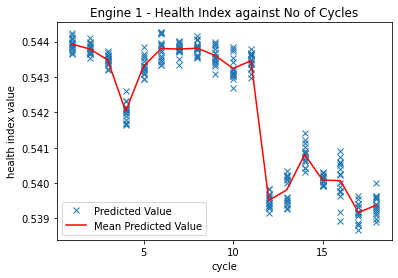

In [ ]:
cycle_f_test = data_cycle[select_engine_to_test_idx]
# First cycle
min_cycle_test = int(min(cycle_f_test))
# Last cycle
max_cycle_test = int(max(cycle_f_test))

# Creating Mean values
hi_pred_mean = []
cycle_plot = []

for i in range(min_cycle_test, max_cycle_test+1):
    hi_mean_row = np.mean(hi_pred.numpy()[np.where(cycle_f_test[:,0] == i)[0]])
    cycle_row = i
    hi_pred_mean.append(hi_mean_row)
    cycle_plot.append(cycle_row)


# Plot the curve
plt.title('Engine '+ str(select_engine_to_test) + ' - Health Index against No of Cycles')
plt.plot(cycle_f_test, hi_pred, 'x', label='Predicted Value')
plt.plot(cycle_plot, hi_pred_mean, '-r', label='Mean Predicted Value')
plt.locator_params(axis='x', integer=True, tight=True)
plt.legend()
plt.xlabel('cycle')
plt.ylabel('health index value')
plt.show()